# Model Default

## Correlaciones

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

In [3]:
df = pd.read_csv('default_ABT2.csv')

In [4]:
df = df.fillna(0)

In [5]:
df.info(show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2844073 entries, 0 to 2844072
Columns: 106 entries, DATE to ANTIGUEDAD_d
dtypes: float64(100), object(6)
memory usage: 2.2+ GB


In [6]:
#test droping roll_sum_60_DEFAULT
df = df.drop(['roll_sum_60_DEFAULT','roll_max_30D_DEFAULT','roll_sum_30_DEFAULT','roll_mean_30D_DEFAULT','roll_sum_7_DEFAULT','roll_max_7D_DEFAULT','roll_mean_7D_DEFAULT','lag_7_DEFAULT'], axis =1)

In [7]:
#drop default e inactive days
df = df.drop(['DEFAULT','INACTIVE_DAYS'], axis =1)

In [37]:
tr = df[df['DATE']< '2023-11-01']
te = df[df['DATE']> '2023-10-31']

In [38]:
tr['DATE'].max()

'2023-10-31'

In [39]:
te['DATE'].min()

'2023-11-01'

In [40]:
tr= tr.select_dtypes(['number'])
te = te.select_dtypes(['number'])

In [41]:
#separar en train y test, nov, dic y ene
X_train = tr.drop(["TARGET"], axis=1)
y_train = tr.TARGET
X_test = te.drop(["TARGET"], axis=1)
y_test = te.TARGET

In [42]:
sttr=  StandardScaler().fit_transform(X_train)
stte=  StandardScaler().fit_transform(X_test)

In [43]:
X_train= pd.DataFrame(data = sttr, columns = X_train.columns, index = X_train.index)
X_test  = pd.DataFrame(data = stte, columns = X_test.columns, index = X_test.index)

In [15]:
# feature engineering
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import StandardScaler


In [14]:
features = X_train.columns
f_scores = f_classif(X_train, y_train)[0] # el [1] son los p-values.

df_fscores = pd.DataFrame({'features':features,'score':f_scores})
df_fscores = df_fscores.sort_values('score', ascending = False)
df_fscores.head(30)

,features,score
97,roll_sum_60_DEFAULT,7774.494212
41,roll_max_30D_DEFAULT,6980.173535
89,roll_sum_30_DEFAULT,6673.870829
17,roll_mean_30D_DEFAULT,5524.691588
81,roll_sum_7_DEFAULT,1602.021100
33,roll_max_7D_DEFAULT,1577.810846
25,roll_mean_7D_DEFAULT,1522.318537
65,lag_7_DEFAULT,331.300780
78,roll_sum_7_TX,288.477945
86,roll_sum_30_TX,261.199837


In [15]:
df_fscores.tail(10)

,features,score
43,lag_1_BALANCE,3.023984
51,lag_2_BALANCE,2.630599
95,roll_sum_60_TX_MO,2.141227
92,roll_sum_60_TOTAL_AMOUNT_MO,2.049660
2,BALANCE,1.941976
67,lag_30_BALANCE,1.587100
59,lag_7_BALANCE,1.171228
8,INACTIVE_DAYS,0.337711
19,roll_mean_7D_BALANCE,0.251412
11,roll_mean_30D_BALANCE,0.013422


In [16]:
# eliminando las features que no son relevantes
LIM_IRR = 5 # ajustable
df_fscores = df_fscores[df_fscores['score'] > LIM_IRR]
X_sel = X_train[df_fscores['features']]
X_sel.shape

(2166913, 86)

In [17]:
# seleccionando las features redundantes
xcorr = X_sel.corr().abs()
LIM_COR = 0.80 # ajustable
xcorr = xcorr[xcorr > LIM_COR].fillna(0)
index = []
column = []
for idx in list(xcorr.index):
    for col in list(xcorr.columns):
        # la matriz es diagonal
        if idx == col:
            break
        if (xcorr.loc[idx,col] != 0):
            index = index + [idx]
            column = column + [col]
df_fcorr = pd.DataFrame({'index':index, 'col':column})
df_fcorr.head(20)

,index,col
0,roll_sum_30_DEFAULT,roll_max_30D_DEFAULT
1,roll_mean_30D_DEFAULT,roll_max_30D_DEFAULT
2,roll_mean_30D_DEFAULT,roll_sum_30_DEFAULT
3,roll_max_7D_DEFAULT,roll_sum_7_DEFAULT
4,roll_mean_7D_DEFAULT,roll_sum_7_DEFAULT
5,roll_mean_7D_DEFAULT,roll_max_7D_DEFAULT
6,roll_sum_30_TX,roll_sum_7_TX
7,roll_sum_7_AMOUNT,roll_sum_7_TX
8,roll_sum_7_AMOUNT,roll_sum_30_TX
9,roll_mean_7D_TX,roll_sum_7_TX


In [18]:
X_train.dtypes

TX                      float64
AMOUNT                  float64
BALANCE                 float64
TX_check                float64
TOTAL_AMOUNT_check      float64
                         ...   
roll_sum_60_TX          float64
roll_sum_60_TX_MO       float64
roll_sum_60_TX_check    float64
roll_sum_60_DEFAULT     float64
ANTIGUEDAD_d            float64
Length: 99, dtype: object

In [19]:
y_train.dtypes

dtype('float64')

In [20]:
y_train.unique()

array([0., 1.])

# Logistic regression

In [34]:
from sklearn.linear_model import LogisticRegression

In [35]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
clf.score(X_train, y_train)

0.9990165733465072

In [44]:
clf.score(X_test, y_test)

0.998899816882273

In [45]:
# Get feature importances
importances = clf.coef_[0]

# Get the feature names (assuming you have them stored in a list called 'feature_names')
feature_names = X_test.columns  # replace with your feature names

# Create DataFrame
fi = pd.DataFrame({'feature': feature_names, 'importance': importances})

# Sort DataFrame by importance
fi = fi.sort_values('importance', ascending=False)

# Print DataFrame
print(fi)

                  feature  importance
33        roll_max_30D_TX    0.116104
8    roll_mean_30D_AMOUNT    0.092883
12       roll_mean_30D_TX    0.072905
29    roll_max_30D_AMOUNT    0.070606
9   roll_mean_30D_BALANCE    0.066219
..                    ...         ...
67      roll_sum_7_AMOUNT   -0.093188
0                      TX   -0.098801
78         roll_sum_30_TX   -0.131874
71          roll_sum_7_TX   -0.140954
88           ANTIGUEDAD_d   -0.205075

[89 rows x 2 columns]


In [46]:
fi.head(30)

,feature,importance
33,roll_max_30D_TX,0.116104
8,roll_mean_30D_AMOUNT,0.092883
12,roll_mean_30D_TX,0.072905
29,roll_max_30D_AMOUNT,0.070606
9,roll_mean_30D_BALANCE,0.066219
84,roll_sum_60_TOTAL_AMOUNT_check,0.057554
87,roll_sum_60_TX_check,0.053117
16,roll_mean_7D_BALANCE,0.049626
77,roll_sum_30_TOTAL_AMOUNT_check,0.041126
66,lag_30_DEFAULT,0.039912


In [47]:
fi.tail(30)

,feature,importance
36,lag_1_AMOUNT,-0.032795
20,roll_mean_7D_TX_MO,-0.033290
25,roll_max_7D_TOTAL_AMOUNT_check,-0.038365
18,roll_mean_7D_TOTAL_AMOUNT_check,-0.039271
11,roll_mean_30D_TOTAL_AMOUNT_check,-0.042535
40,lag_1_TX,-0.044868
44,lag_2_AMOUNT,-0.046321
10,roll_mean_30D_TOTAL_AMOUNT_MO,-0.049003
19,roll_mean_7D_TX,-0.050124
21,roll_mean_7D_TX_check,-0.050728


In [48]:
X_train['proba'] = clf.predict_proba(X_train)[:, 1]

In [49]:
X_test['proba'] = clf.predict_proba(X_test)[:, 1]

In [50]:
percentiles = pd.qcut(X_test['proba'], 10, labels=False, duplicates='drop')
percentile_label = {p: l for l, p in enumerate(sorted(percentiles.unique(), reverse=True), start=1)}
percentiles = percentiles.map(percentile_label)
X_test['deciles'] = percentiles
X_test['deciles'] = X_test['deciles'].astype('Int32')


In [51]:
X_test.shape

(677160, 91)

In [52]:
y_test.shape

(677160,)

In [53]:
y_test.sum()

742.0

In [54]:
Aux = pd.merge(X_test, y_test, left_index=True,right_index=True, how='left')

In [55]:
Aux.shape

(677160, 92)

In [56]:
Aux.columns

Index(['TX', 'AMOUNT', 'BALANCE', 'TX_check', 'TOTAL_AMOUNT_check', 'TX_MO',
       'TOTAL_AMOUNT_MO', 'DSO_DEPO_DAY', 'roll_mean_30D_AMOUNT',
       'roll_mean_30D_BALANCE', 'roll_mean_30D_TOTAL_AMOUNT_MO',
       'roll_mean_30D_TOTAL_AMOUNT_check', 'roll_mean_30D_TX',
       'roll_mean_30D_TX_MO', 'roll_mean_30D_TX_check', 'roll_mean_7D_AMOUNT',
       'roll_mean_7D_BALANCE', 'roll_mean_7D_TOTAL_AMOUNT_MO',
       'roll_mean_7D_TOTAL_AMOUNT_check', 'roll_mean_7D_TX',
       'roll_mean_7D_TX_MO', 'roll_mean_7D_TX_check', 'roll_max_7D_AMOUNT',
       'roll_max_7D_BALANCE', 'roll_max_7D_TOTAL_AMOUNT_MO',
       'roll_max_7D_TOTAL_AMOUNT_check', 'roll_max_7D_TX', 'roll_max_7D_TX_MO',
       'roll_max_7D_TX_check', 'roll_max_30D_AMOUNT', 'roll_max_30D_BALANCE',
       'roll_max_30D_TOTAL_AMOUNT_MO', 'roll_max_30D_TOTAL_AMOUNT_check',
       'roll_max_30D_TX', 'roll_max_30D_TX_MO', 'roll_max_30D_TX_check',
       'lag_1_AMOUNT', 'lag_1_BALANCE', 'lag_1_TOTAL_AMOUNT_MO',
       'lag_1_TOTAL

In [57]:
Aux['TARGET'].sum()

742.0

In [58]:
aux1 = Aux.groupby('deciles')['TARGET'].sum()

In [59]:
aux1

deciles
1     210.0
2     159.0
3      85.0
4      83.0
5      79.0
6      45.0
7      49.0
8      16.0
9      14.0
10      2.0
Name: TARGET, dtype: float64

# XGBOOST

In [16]:
from sklearn.ensemble import GradientBoostingClassifier

In [17]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
    max_depth=1, random_state=0).fit(X_train, y_train)
clf.score(X_test, y_test)

0.9989042471498611

In [18]:
clf.score(X_train, y_train)

0.9989958064767713

In [19]:
from sklearn.metrics import classification_report

In [20]:
print(classification_report(y_test,clf.predict(X_test)))

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    676418
         1.0       0.00      0.00      0.00       742

    accuracy                           1.00    677160
   macro avg       0.50      0.50      0.50    677160
weighted avg       1.00      1.00      1.00    677160



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [21]:
# Get feature importances
importances = clf.feature_importances_

# Get the feature names (assuming you have them stored in a list called 'feature_names')
feature_names = X_test.columns  # replace with your feature names

# Create DataFrame
fi = pd.DataFrame({'feature': feature_names, 'importance': importances})

# Sort DataFrame by importance
fi = fi.sort_values('importance', ascending=False)

# Print DataFrame
print(fi)


                           feature  importance
88                    ANTIGUEDAD_d    0.999420
71                   roll_sum_7_TX    0.000169
28            roll_max_7D_TX_check    0.000098
8             roll_mean_30D_AMOUNT    0.000071
44                    lag_2_AMOUNT    0.000064
..                             ...         ...
30            roll_max_30D_BALANCE    0.000000
27               roll_max_7D_TX_MO    0.000000
26                  roll_max_7D_TX    0.000000
25  roll_max_7D_TOTAL_AMOUNT_check    0.000000
37                   lag_1_BALANCE    0.000000

[89 rows x 2 columns]


In [33]:
fi.head(30)

,feature,importance
88,ANTIGUEDAD_d,0.999420
71,roll_sum_7_TX,0.000169
28,roll_max_7D_TX_check,0.000098
8,roll_mean_30D_AMOUNT,0.000071
44,lag_2_AMOUNT,0.000064
9,roll_mean_30D_BALANCE,0.000064
7,DSO_DEPO_DAY,0.000041
1,AMOUNT,0.000029
52,lag_7_AMOUNT,0.000021
36,lag_1_AMOUNT,0.000010


In [22]:
X_test['proba'] = clf.predict_proba(X_test)[:, 1]

In [23]:
percentiles = pd.qcut(X_test['proba'], 10, labels=False, duplicates='drop')
percentile_label = {p: l for l, p in enumerate(sorted(percentiles.unique(), reverse=True), start=1)}
percentiles = percentiles.map(percentile_label)
X_test['deciles'] = percentiles
X_test['deciles'] = X_test['deciles'].astype('Int32')


In [24]:
X_test.shape

(677160, 91)

In [25]:
y_test.shape

(677160,)

In [26]:
y_test.sum()

742.0

In [27]:
Aux = pd.merge(X_test, y_test, left_index=True,right_index=True, how='left')

In [28]:
Aux.shape

(677160, 92)

In [29]:
Aux.columns

Index(['TX', 'AMOUNT', 'BALANCE', 'TX_check', 'TOTAL_AMOUNT_check', 'TX_MO',
       'TOTAL_AMOUNT_MO', 'DSO_DEPO_DAY', 'roll_mean_30D_AMOUNT',
       'roll_mean_30D_BALANCE', 'roll_mean_30D_TOTAL_AMOUNT_MO',
       'roll_mean_30D_TOTAL_AMOUNT_check', 'roll_mean_30D_TX',
       'roll_mean_30D_TX_MO', 'roll_mean_30D_TX_check', 'roll_mean_7D_AMOUNT',
       'roll_mean_7D_BALANCE', 'roll_mean_7D_TOTAL_AMOUNT_MO',
       'roll_mean_7D_TOTAL_AMOUNT_check', 'roll_mean_7D_TX',
       'roll_mean_7D_TX_MO', 'roll_mean_7D_TX_check', 'roll_max_7D_AMOUNT',
       'roll_max_7D_BALANCE', 'roll_max_7D_TOTAL_AMOUNT_MO',
       'roll_max_7D_TOTAL_AMOUNT_check', 'roll_max_7D_TX', 'roll_max_7D_TX_MO',
       'roll_max_7D_TX_check', 'roll_max_30D_AMOUNT', 'roll_max_30D_BALANCE',
       'roll_max_30D_TOTAL_AMOUNT_MO', 'roll_max_30D_TOTAL_AMOUNT_check',
       'roll_max_30D_TX', 'roll_max_30D_TX_MO', 'roll_max_30D_TX_check',
       'lag_1_AMOUNT', 'lag_1_BALANCE', 'lag_1_TOTAL_AMOUNT_MO',
       'lag_1_TOTAL

In [30]:
Aux['TARGET'].sum()

742.0

In [31]:
aux1 = Aux.groupby('deciles')['TARGET'].sum()

In [32]:
aux1

deciles
1     228.0
2      81.0
3      61.0
4     100.0
5      40.0
6      80.0
7      41.0
8      86.0
9      19.0
10      6.0
Name: TARGET, dtype: float64

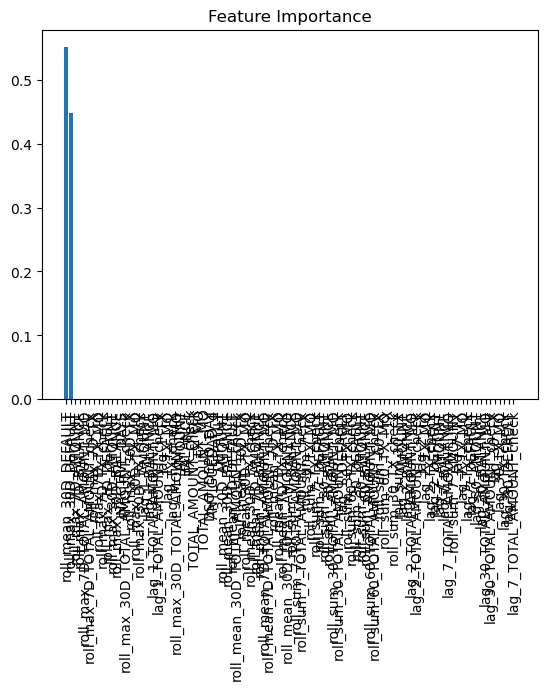

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importances
importances = clf.feature_importances_

# Get the feature names (assuming you have them stored in a list called 'feature_names')
feature_names = X_test.columns  # replace with your feature names

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [feature_names[i] for i in indices]

# Create plot
plt.figure()

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(len(importances)), importances[indices])

# Add feature names as x-axis labels
plt.xticks(range(len(importances)), names, rotation=90)

# Show plot
plt.show()


In [27]:
X_train.shape

(2166913, 98)

In [28]:
X_test.shape

(677160, 98)

In [16]:
X_train.head(10)

,TX,AMOUNT,BALANCE,TX_check,TOTAL_AMOUNT_check,TX_MO,TOTAL_AMOUNT_MO,DSO_DEPO_DAY,INACTIVE_DAYS,DEFAULT,...,roll_sum_30_DEFAULT,roll_sum_60_AMOUNT,roll_sum_60_BALANCE,roll_sum_60_TOTAL_AMOUNT_MO,roll_sum_60_TOTAL_AMOUNT_check,roll_sum_60_TX,roll_sum_60_TX_MO,roll_sum_60_TX_check,roll_sum_60_DEFAULT,ANTIGUEDAD_d
0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1552.0
1,0.0,0.0,13853.8257,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1553.0
2,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1554.0
3,1.0,340.0,13853.8257,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1555.0
4,1.0,25.0,14202.1057,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1556.0
5,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1557.0
6,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1558.0
7,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1559.0
8,6.0,6.0,14232.1057,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1560.0
9,1.0,1.0,14268.1057,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1561.0


In [17]:
df.head(10)

,DATE,ID_BRANCH,TX,AMOUNT,BALANCE,TX_check,TOTAL_AMOUNT_check,TX_MO,TOTAL_AMOUNT_MO,DSO_DEPO_DAY,...,roll_sum_30_DEFAULT,roll_sum_60_AMOUNT,roll_sum_60_BALANCE,roll_sum_60_TOTAL_AMOUNT_MO,roll_sum_60_TOTAL_AMOUNT_check,roll_sum_60_TX,roll_sum_60_TX_MO,roll_sum_60_TX_check,roll_sum_60_DEFAULT,ANTIGUEDAD_d
0,2023-01-01,A00002,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1552.0
1,2023-01-02,A00002,0.0,0.0,13853.8257,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1553.0
2,2023-01-03,A00002,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1554.0
3,2023-01-04,A00002,1.0,340.0,13853.8257,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1555.0
4,2023-01-05,A00002,1.0,25.0,14202.1057,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1556.0
5,2023-01-06,A00002,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1557.0
6,2023-01-07,A00002,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1558.0
7,2023-01-08,A00002,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1559.0
8,2023-01-09,A00002,6.0,6.0,14232.1057,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1560.0
9,2023-01-10,A00002,1.0,1.0,14268.1057,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1561.0


In [29]:
X_train['roll_max_30D_DEFAULT'].unique()

array([0., 1.])

In [30]:
X_train['roll_max_30D_DEFAULT'].unique()

array([0., 1.])

/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


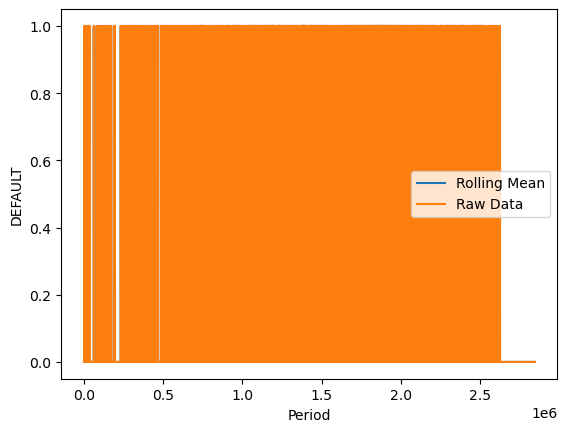

In [33]:
import matplotlib.pyplot as plt
plt.plot(X_train['roll_max_30D_DEFAULT'], label='Rolling Mean')
plt.plot(y_train, label='Raw Data')
plt.legend()
plt.ylabel('DEFAULT')
plt.xlabel('Period')
plt.show()

In [63]:
y_train.sum()

2131.0

In [64]:
y_test.sum()

742.0

In [65]:
y_train.shape

(2166913,)

In [66]:
2131/2166913*100

0.09834266534927798

In [ ]:
el 0.098% es target, modelo que sólo predice 0 tiene 99.912% de aciertos

# Dimensionar casos de default de 1 semana

In [6]:
# lunes 4 de septiembre a domingo 10
tr = df[df['DATE']< '2023-09-11']
te = tr[tr['DATE']> '2023-09-03']

In [7]:
te['DEFAULT'].sum()

33.0

In [8]:
te['TARGET'].sum()

58.0

In [9]:
te.shape

(49896, 106)

In [10]:
# % de default
33/49896*100

0.06613756613756613

In [11]:
# % de target
58/49896*100

0.11624178290844957

In [13]:
lu = te[te['DATE']== '2023-09-04']

In [16]:
print (lu['DEFAULT'].sum()/len(lu)*100)
print (lu['TARGET'].sum()/len(lu)*100)

0.05611672278338946
0.2665544332210999


In [17]:
ma = te[te['DATE']== '2023-09-05']
print (ma['DEFAULT'].sum()/len(ma)*100)
print (ma['TARGET'].sum()/len(ma)*100)

0.16835016835016833
0.12626262626262627


In [18]:
mi = te[te['DATE']== '2023-09-06']
print (mi['DEFAULT'].sum()/len(mi)*100)
print (mi['TARGET'].sum()/len(mi)*100)

0.09820426487093155
0.11223344556677892


In [19]:
ju = te[te['DATE']== '2023-09-07']
print (ju['DEFAULT'].sum()/len(ju)*100)
print (ju['TARGET'].sum()/len(ju)*100)

0.014029180695847365
0.014029180695847365


In [20]:
vi = te[te['DATE']== '2023-09-08']
print (vi['DEFAULT'].sum()/len(vi)*100)
print (vi['TARGET'].sum()/len(vi)*100)

0.08417508417508417
0.0


In [21]:
sa = te[te['DATE']== '2023-09-09']
print (sa['DEFAULT'].sum()/len(sa)*100)
print (sa['TARGET'].sum()/len(sa)*100)

0.04208754208754208
0.23849607182940516


In [22]:
do = te[te['DATE']== '2023-09-10']
print (do['DEFAULT'].sum()/len(do)*100)
print (do['TARGET'].sum()/len(do)*100)

0.0
0.05611672278338946


In [24]:
print (lu['DEFAULT'].sum()/len(lu)*100)
print (ma['DEFAULT'].sum()/len(ma)*100)
print (mi['DEFAULT'].sum()/len(mi)*100)
print (ju['DEFAULT'].sum()/len(ju)*100)
print (vi['DEFAULT'].sum()/len(vi)*100)
print (sa['DEFAULT'].sum()/len(sa)*100)
print (do['DEFAULT'].sum()/len(do)*100)

0.05611672278338946
0.16835016835016833
0.09820426487093155
0.014029180695847365
0.08417508417508417
0.04208754208754208
0.0


In [25]:
print (lu['TARGET'].sum()/len(lu)*100)
print (ma['TARGET'].sum()/len(ma)*100)
print (mi['TARGET'].sum()/len(mi)*100)
print (ju['TARGET'].sum()/len(ju)*100)
print (vi['TARGET'].sum()/len(vi)*100)
print (sa['TARGET'].sum()/len(sa)*100)
print (do['TARGET'].sum()/len(do)*100)

0.2665544332210999
0.12626262626262627
0.11223344556677892
0.014029180695847365
0.0
0.23849607182940516
0.05611672278338946
